In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from google.colab import drive
drive.mount('/content/drive')
with open('/content/drive/MyDrive/sentiment_analysis_amazon_data_set/train.ft.txt', 'r') as file:
    lines = file.readlines()

# Split the lines and extract the text and sentiment labels
data = {'text': [], 'sentiment': []}
for line in lines:
    parts = line.strip().split(' ', 1)
    sentiment = parts[0]
    text = parts[1]
    data['text'].append(text)
    data['sentiment'].append(sentiment)

# Create a DataFrame with the extracted values
df = pd.DataFrame(data)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.shape

(3600000, 2)

In [ ]:
df.head(5)

,text,sentiment
0,Stuning even for the non-gamer: This sound tra...,__label__2
1,The best soundtrack ever to anything.: I'm rea...,__label__2
2,Amazing!: This soundtrack is my favorite music...,__label__2
3,Excellent Soundtrack: I truly like this soundt...,__label__2
4,"Remember, Pull Your Jaw Off The Floor After He...",__label__2


"Due to limited computing resources, we have taken a sample from the dataset consisting of 3.6 million data points. This sample will be used to train and test our model, as it is more feasible to work with a smaller subset of data given the resource constraints."

In [ ]:
random_seed = 42
pd.np.random.seed(random_seed)

# Get a random sample of 100,000 reviews
sample_size = 100000
sample_df = df.sample(n=sample_size)

# Reset the index of the sample DataFrame
sample_df.reset_index(drop=True, inplace=True)

# Print the sample DataFrame
sample_df.head()

<ipython-input-5-07a8ad54ce42>:2: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  pd.np.random.seed(random_seed)


,text,sentiment
0,Expensive Junk: This product consists of a pie...,__label__1
1,"Toast too dark: Even on the lowest setting, th...",__label__1
2,Excellent imagery...dumbed down story: I enjoy...,__label__2
3,Are we pretending everyone is married?: The au...,__label__1
4,Not worth your time: Might as well just use a ...,__label__1


In [ ]:
#df['sentiment'].value_counts()

null_values = sample_df.isnull().any()
# Print the columns with null values
print(null_values)

text         False
sentiment    False
dtype: bool


In [ ]:
# Filter the independent features
X =list(sample_df['text'])
y = list(sample_df['sentiment'])

In [ ]:
y=list(pd.get_dummies(y,drop_first=True)['__label__2'])

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20, random_state = 0)

In [ ]:
!pip install transformers

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(X_train,truncation=True,padding=True)
test_encodings = tokenizer(X_test, truncation = True, padding = True)

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [ ]:
from transformers import TFDistilBertForSequenceClassification, TFTrainer , TFTrainingArguments
# Define the training arguments
training_args = TFTrainingArguments(
    output_dir='./results',           # Directory to save checkpoints and final model
    num_train_epochs=2,               # Number of training epochs
    per_device_train_batch_size=16,   # Batch size for training
    per_device_eval_batch_size=32,    # Batch size for evaluation
    learning_rate=2e-5,               # Learning rate
    logging_steps=100,                # Log training progress every 100 steps
    save_steps=500,                   # Save checkpoints every 500 steps
    evaluation_strategy="steps",      # Evaluate model every `logging_steps` steps
    save_total_limit=3,               # Maximum number of checkpoints to keep
)

In [ ]:
with training_args.strategy.scope():
  model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

trainer = TFTrainer(
    model =model,
    args = training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)
trainer.train()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [17]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.13116954345703125}

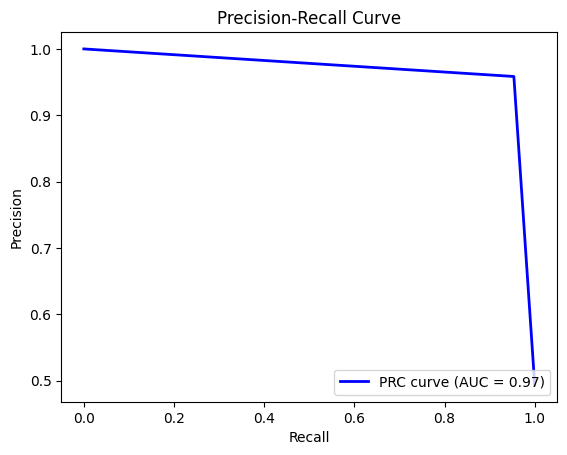

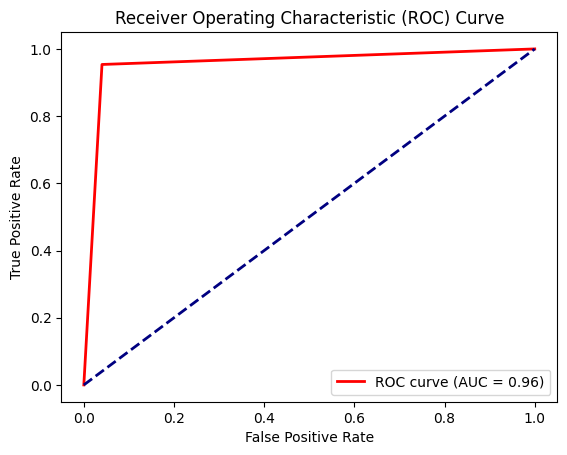

Precision: [0.49365    0.95846906 1.        ]
Recall: [1.         0.95371214 0.        ]
F1 Score: 0.9560846829466416
PRC AUC: 0.967515599803168
ROC AUC: 0.9567119030628449


In [21]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluate the model on the test dataset
pred_logits, _, _ = trainer.predict(test_dataset)
pred_probs = np.argmax(pred_logits, axis=1)
true_labels = y_test

# Convert predicted probabilities to binary labels
pred_labels = np.where(pred_probs == 1, 1, 0)

# Calculate precision, recall, and F1 score
precision = precision_score(true_labels, pred_labels)
recall = recall_score(true_labels, pred_labels)
f1 = f1_score(true_labels, pred_labels)

# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(true_labels, pred_probs)
prc_auc = auc(recall, precision)

# Calculate ROC curve
fpr, tpr, _ = roc_curve(true_labels, pred_probs)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='b', lw=2, label='PRC curve (AUC = %0.2f)' % prc_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='r', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("PRC AUC:", prc_auc)
print("ROC AUC:", roc_auc)


